# From Enteric Fermentation to Forecasts: A Data-Driven Approach to Agricultural Emission Modeling (1961–2019)

Import Necessary Libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas as gpd
#import geodatasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor

# Setup
sns.set_style('darkgrid')

Load the Dataset

In [2]:
df = pd.read_csv("FAOSTAT_data_1961_2019.csv")
print("Initial shape:", df.shape)
df.info()


Initial shape: (33434, 68)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33434 entries, 0 to 33433
Data columns (total 68 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Area Code     33434 non-null  int64  
 1   Area          33434 non-null  object 
 2   Item Code     33434 non-null  int64  
 3   Item          33434 non-null  object 
 4   Element Code  33434 non-null  int64  
 5   Element       33434 non-null  object 
 6   Source Code   33434 non-null  int64  
 7   Source        33434 non-null  object 
 8   Unit          33434 non-null  object 
 9   Y1961         9695 non-null   float64
 10  Y1962         9695 non-null   float64
 11  Y1963         9695 non-null   float64
 12  Y1964         9705 non-null   float64
 13  Y1965         9705 non-null   float64
 14  Y1966         9720 non-null   float64
 15  Y1967         9728 non-null   float64
 16  Y1968         9754 non-null   float64
 17  Y1969         9764 non-null   float64
 18 

Check for duplicates and drop them

In [3]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
df.drop_duplicates(inplace=True)

Number of duplicate rows: 0


Display Basic Info

In [4]:
df.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Source Code,Source,Unit,Y1961,...,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019
0,2,Afghanistan,5058,Enteric Fermentation,7225,Emissions (CH4),3050,FAO TIER 1,kilotonnes,240.6831,...,401.068,402.513,396.921,393.093,398.287,383.3023,380.8767,371.2863,378.8870,389.6563
1,2,Afghanistan,5058,Enteric Fermentation,7225,Emissions (CH4),3051,UNFCCC,kilotonnes,NaN,...,NaN,NaN,NaN,414.000,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Afghanistan,5058,Enteric Fermentation,724413,Emissions (CO2eq) from CH4 (AR5),3050,FAO TIER 1,kilotonnes,6739.1279,...,11229.904,11270.364,11113.788,11006.604,11152.036,10732.4631,10664.5483,10396.0163,10608.8357,10910.3754
3,2,Afghanistan,5058,Enteric Fermentation,724413,Emissions (CO2eq) from CH4 (AR5),3051,UNFCCC,kilotonnes,NaN,...,NaN,NaN,NaN,11592.000,NaN,NaN,NaN,NaN,NaN,NaN
4,2,Afghanistan,5058,Enteric Fermentation,723113,Emissions (CO2eq) (AR5),3050,FAO TIER 1,kilotonnes,6739.1279,...,11229.904,11270.364,11113.788,11006.604,11152.036,10732.4631,10664.5483,10396.0163,10608.8357,10910.3754


Calculate Missing Values

In [5]:
# Missing value percentages
missing_percent = df.isnull().mean() * 100
print("Missing Percentage per Column:")
print(missing_percent[missing_percent > 0])

Missing Percentage per Column:
Y1961    71.002572
Y1962    71.002572
Y1963    71.002572
Y1964    70.972663
Y1965    70.972663
Y1966    70.927798
Y1967    70.903870
Y1968    70.826105
Y1969    70.796195
Y1970    70.772268
Y1971    70.742358
Y1972    70.682539
Y1973    70.667584
Y1974    70.622719
Y1975    70.562900
Y1976    70.532990
Y1977    70.532990
Y1978    70.547945
Y1979    70.532990
Y1980    70.518036
Y1981    70.497099
Y1982    70.497099
Y1983    70.512054
Y1984    70.497099
Y1985    70.512054
Y1986    70.532990
Y1987    70.532990
Y1988    70.532990
Y1989    70.532990
Y1990    19.919842
Y1991    20.562900
Y1992    12.813304
Y1993    11.769456
Y1994     7.952982
Y1995    11.102471
Y1996    11.491296
Y1997    11.431477
Y1998    11.401567
Y1999    11.506251
Y2000     6.840342
Y2001    12.412514
Y2002    12.146318
Y2003    11.889095
Y2004    12.089490
Y2005    11.392594
Y2006    11.395585
Y2007    11.826285
Y2008    11.913023
Y2009    11.981815
Y2010    10.875157
Y2011    12.289885


Merging columns in groups of 5

In [6]:
# Copy of original data
df_grouped = df.copy()

# Identify year columns
year_cols = [col for col in df_grouped.columns if col.startswith('Y') and col[1:].isdigit()]
year_nums = sorted([int(col[1:]) for col in year_cols])

# Create 5-year average columns
intervals = [(start, min(start + 4, max(year_nums))) for start in range(min(year_nums), max(year_nums)+1, 5)]
for start, end in intervals:
    group_cols = [f'Y{year}' for year in range(start, end+1) if f'Y{year}' in df_grouped.columns]
    if group_cols:
        interval_name = f'{start}_{end}'
        df_grouped[interval_name] = df_grouped[group_cols].mean(axis=1)

In [7]:
# Save copy for visualization
df_grouped_before = df_grouped.copy()

# Drop original years
df_grouped.drop(columns=year_cols, inplace=True)
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33434 entries, 0 to 33433
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Area Code     33434 non-null  int64  
 1   Area          33434 non-null  object 
 2   Item Code     33434 non-null  int64  
 3   Item          33434 non-null  object 
 4   Element Code  33434 non-null  int64  
 5   Element       33434 non-null  object 
 6   Source Code   33434 non-null  int64  
 7   Source        33434 non-null  object 
 8   Unit          33434 non-null  object 
 9   1961_1965     9705 non-null   float64
 10  1966_1970     9772 non-null   float64
 11  1971_1975     9842 non-null   float64
 12  1976_1980     9872 non-null   float64
 13  1981_1985     9874 non-null   float64
 14  1986_1990     26789 non-null  float64
 15  1991_1995     31475 non-null  float64
 16  1996_2000     31358 non-null  float64
 17  2001_2005     29932 non-null  float64
 18  2006_2010     30133 non-nu

In [32]:
grouped_columns = [
    '1961_1965', '1966_1970', '1971_1975', '1976_1980',
    '1981_1985', '1986_1990', '1991_1995', '1996_2000',
    '2001_2005', '2006_2010', '2011_2015', '2016_2019'
]


 Emission Source Comparison 

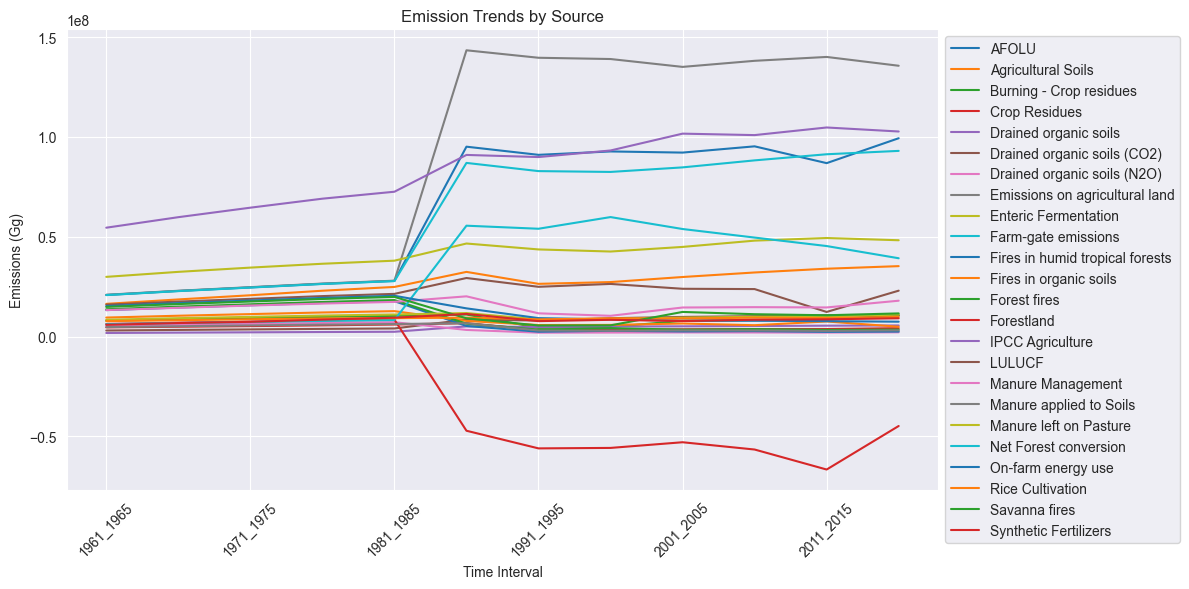

In [34]:
sources = df_grouped.groupby('Item')[grouped_columns].sum().T
sources.plot(figsize=(12,6))
plt.title("Emission Trends by Source")
plt.xlabel("Time Interval")
plt.ylabel("Emissions (Gg)")
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


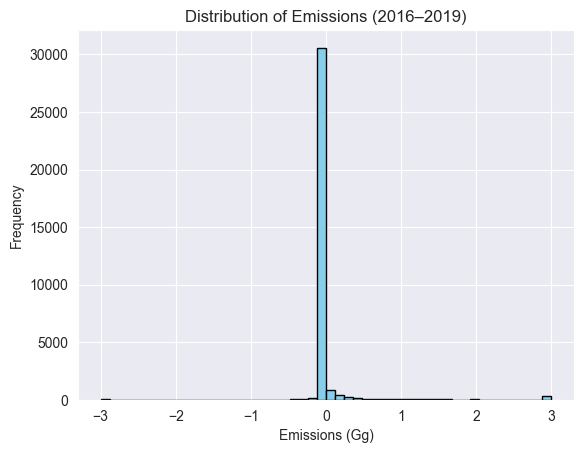

In [35]:
plt.hist(df['2016_2019'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Emissions (2016–2019)')
plt.xlabel('Emissions (Gg)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


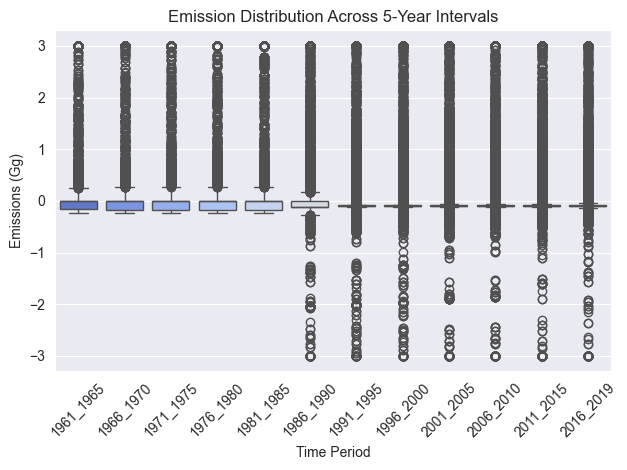

In [36]:
sns.boxplot(data=df[grouped_columns], palette='coolwarm')
plt.title("Emission Distribution Across 5-Year Intervals")
plt.xlabel("Time Period")
plt.ylabel("Emissions (Gg)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


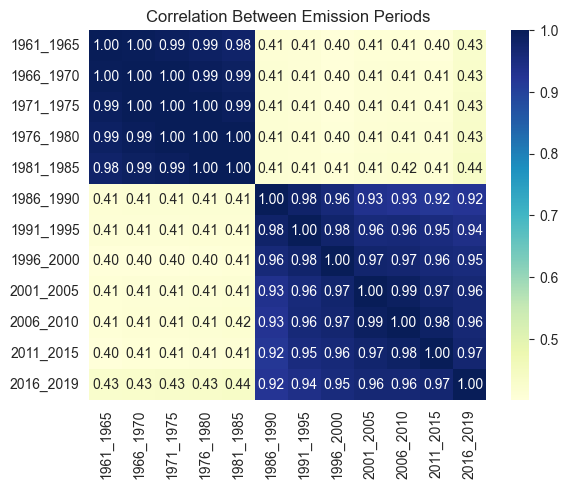

In [37]:
corr = df[grouped_columns].corr()
sns.heatmap(corr, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Correlation Between Emission Periods")
plt.show()


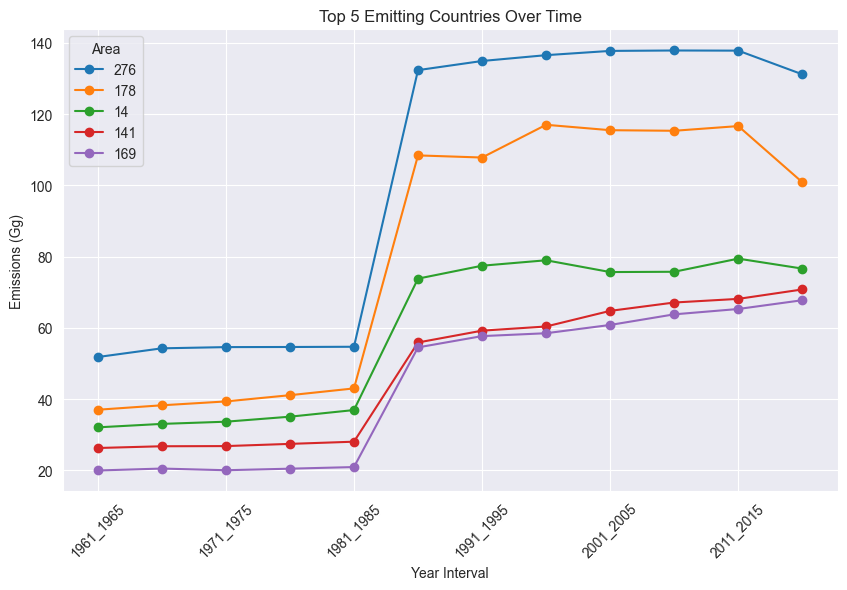

In [38]:
top5 = df.groupby('Area')[grouped_columns].sum().sort_values('2016_2019', ascending=False).head(5)
top5.T.plot(figsize=(10, 6), marker='o')
plt.title("Top 5 Emitting Countries Over Time")
plt.xlabel("Year Interval")
plt.ylabel("Emissions (Gg)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


                
India     - 276           
Brazil    - 178         
China     - 14            
USA       - 141          
Indonesia - 169          

Global Emission Trend

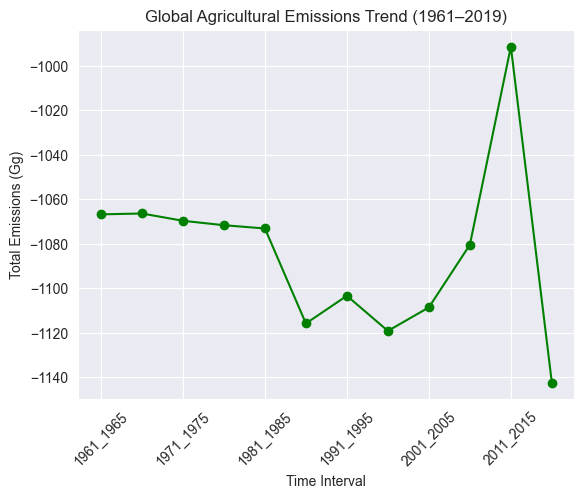

In [39]:
global_trend = df[grouped_columns].sum()
global_trend.plot(marker='o', color='green')
plt.title("Global Agricultural Emissions Trend (1961–2019)")
plt.xlabel("Time Interval")
plt.ylabel("Total Emissions (Gg)")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


Handle missing values

In [8]:

for col in df_grouped.columns:
    null_ratio = df_grouped[col].isnull().mean()
    if null_ratio > 0:
        if null_ratio < 0.05:
            df_grouped.dropna(subset=[col], inplace=True)
        elif df_grouped[col].dtype in ['float64', 'int64']:
            df_grouped[col] = df_grouped[col].fillna(df_grouped[col].mean())
        else:
            df_grouped[col] = df_grouped[col].fillna(df_grouped[col].mode()[0])

C:\Users\Mahir\AppData\Local\Temp\ipykernel_5116\1267779261.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5_missing.index, y=top5_missing.values, palette='magma')


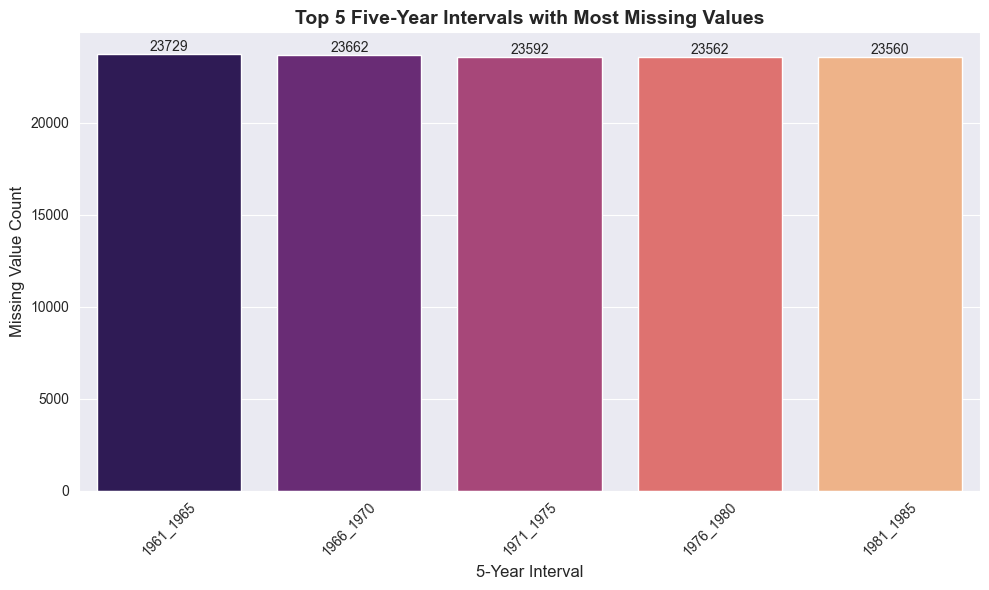

In [9]:
# Visualize top 5 5-year columns with most missing values
five_year_cols = [col for col in df_grouped.columns if '_' in col and col.replace('_','').isdigit()]
missing_counts = df_grouped_before[five_year_cols].isnull().sum().sort_values(ascending=False)
top5_missing = missing_counts.head(5)
plt.figure(figsize=(10, 6))
sns.barplot(x=top5_missing.index, y=top5_missing.values, palette='magma')
plt.title("Top 5 Five-Year Intervals with Most Missing Values", fontsize=14, fontweight='bold')
plt.xlabel("5-Year Interval", fontsize=12)
plt.ylabel("Missing Value Count", fontsize=12)
for i, val in enumerate(top5_missing.values):
    plt.text(i, val + 5, str(val), ha='center', va='bottom', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


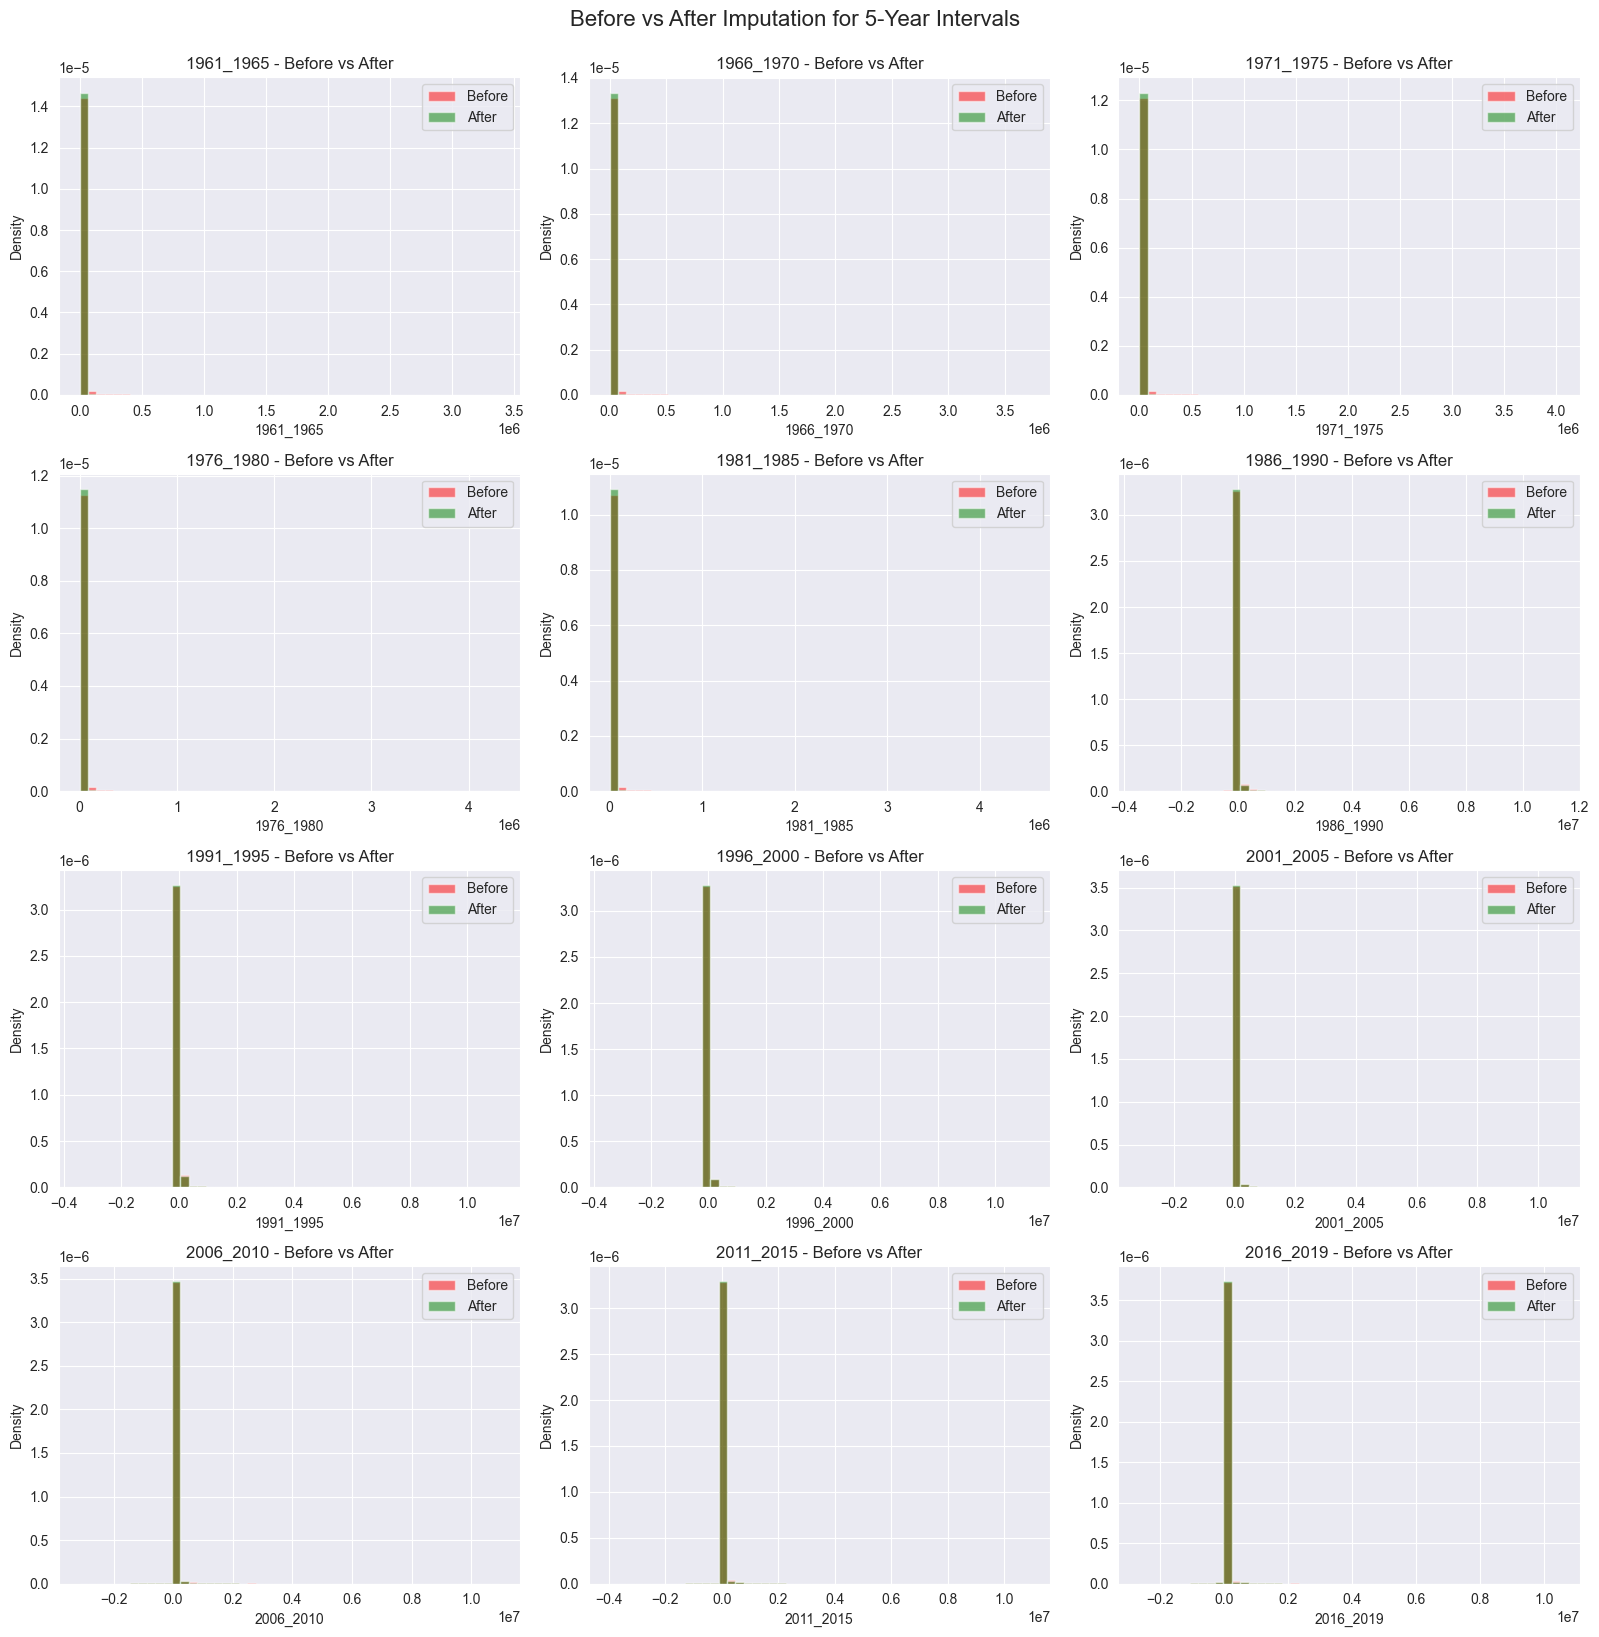

In [10]:
# Histograms before vs after missing value handling
interval_cols = [col for col in df_grouped.columns if col.count('_') == 1 and col.replace('_','').isdigit()]
n_cols = 3
n_rows = int(np.ceil(len(interval_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(interval_cols):
    ax = axes[i]
    before = df_grouped_before[col].dropna()
    after = df_grouped[col].dropna()

    ax.hist(before, bins=50, alpha=0.5, label='Before', color='red', density=True)
    ax.hist(after, bins=50, alpha=0.5, label='After', color='green', density=True)
    ax.set_title(f"{col} - Before vs After")
    ax.set_xlabel(col)
    ax.set_ylabel("Density")
    ax.legend()

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Before vs After Imputation for 5-Year Intervals", fontsize=16, y=1.02)
plt.show()



Axis	Meaning

X-axis	Merged values for a specific 5-year period (actual data values)        
Y-axis	Probability density (or frequency if density=False)

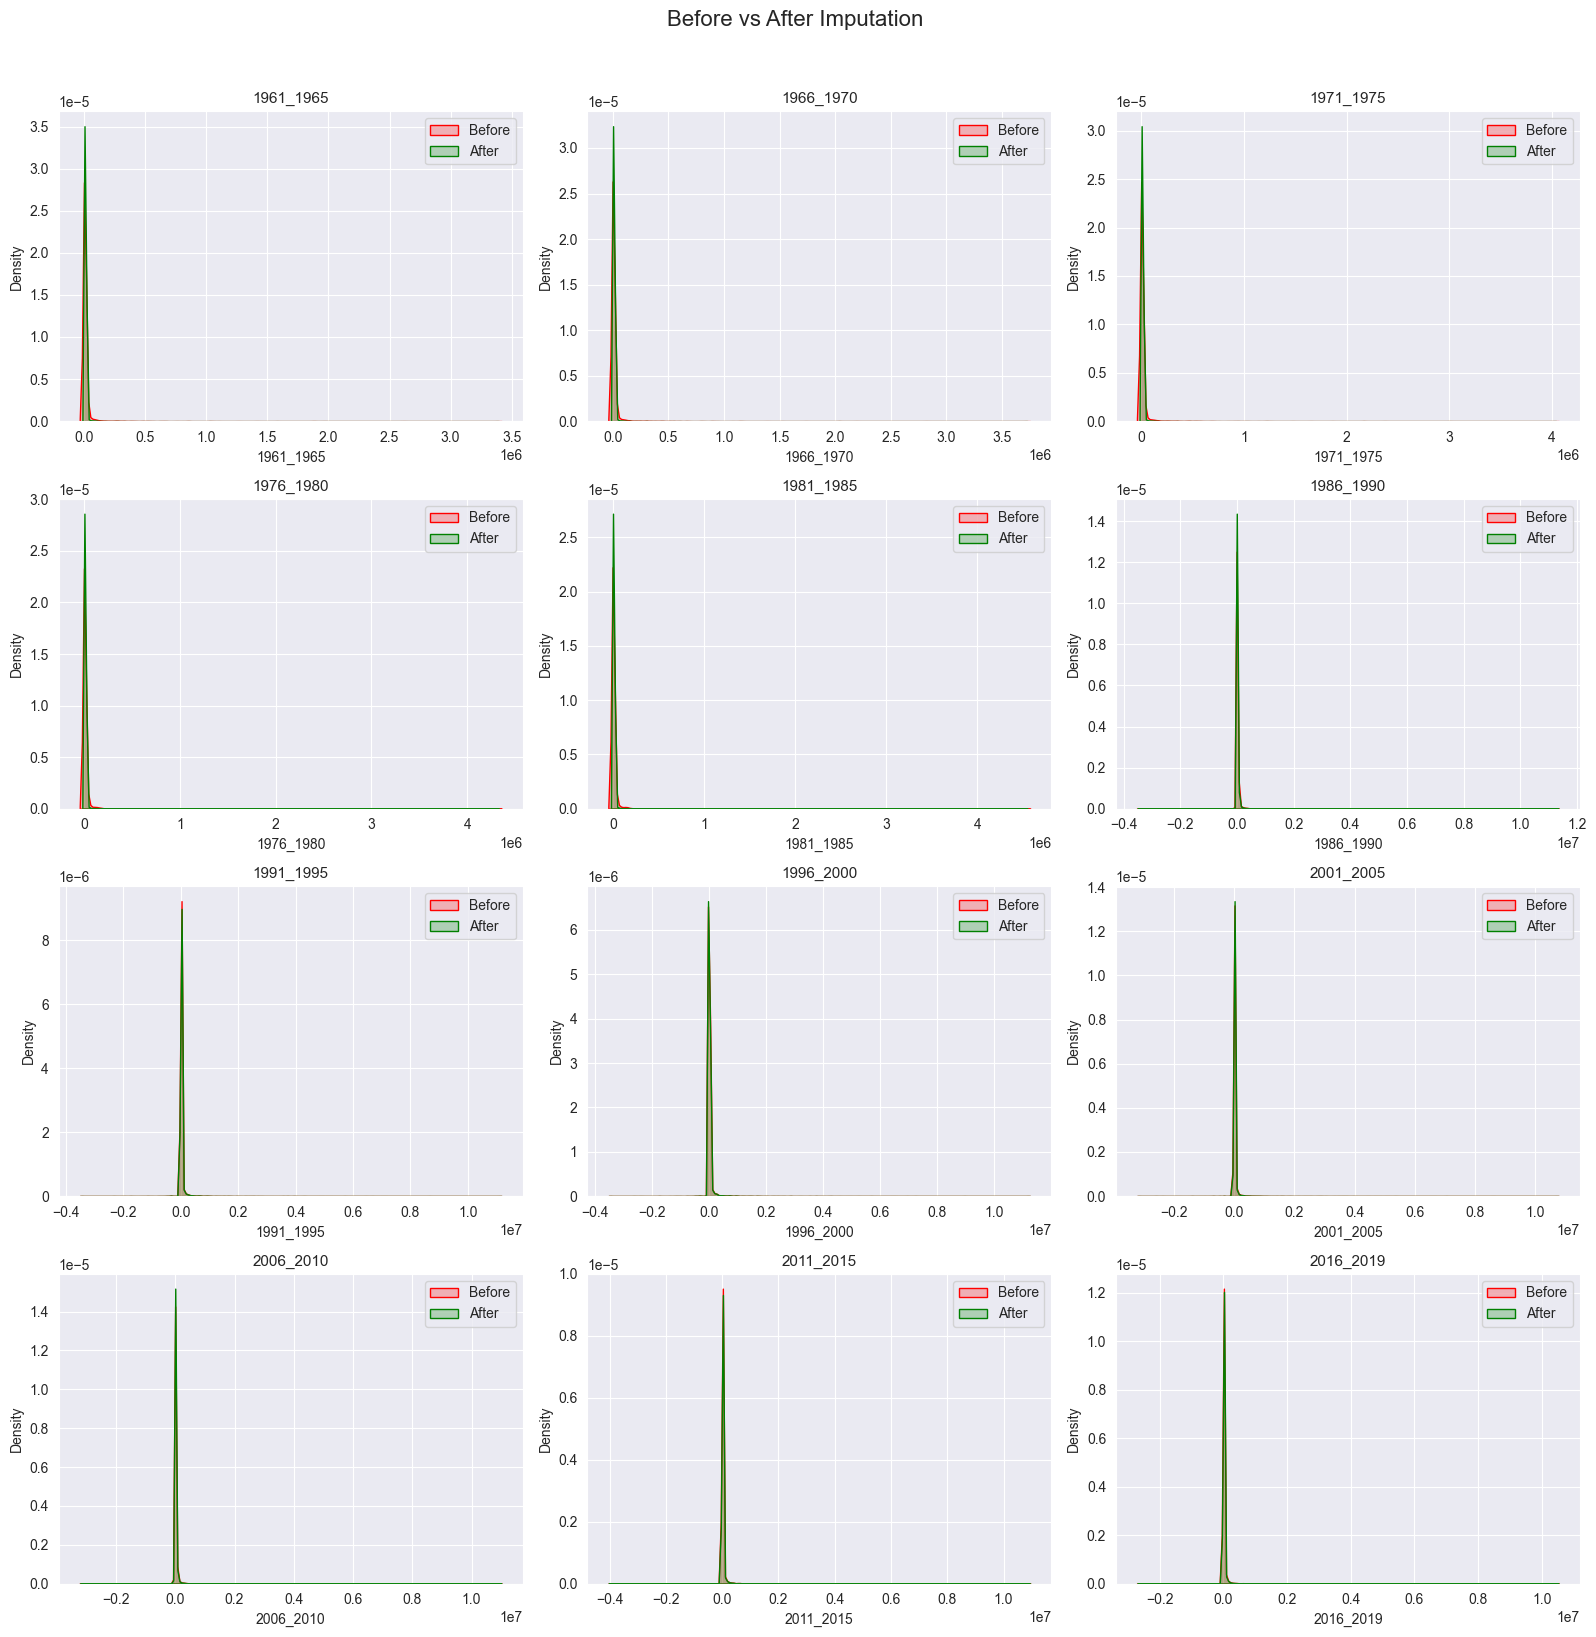

In [11]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()
for i, col in enumerate(interval_cols):
    sns.kdeplot(df_grouped_before[col].dropna(), ax=axes[i], label='Before', color='red', fill=True)
    sns.kdeplot(df_grouped[col], ax=axes[i], label='After', color='green', fill=True)
    axes[i].set_title(f"{col}", fontsize=11)
    axes[i].legend()
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.suptitle("Before vs After Imputation", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [12]:
# Identify 5-year columns
interval_cols = [col for col in df_grouped.columns if col.count('_') == 1 and col.replace('_','').isdigit()]

# Standard Scaling
df_scaled_std = df_grouped.copy()
df_scaled_std[interval_cols] = StandardScaler().fit_transform(df_scaled_std[interval_cols])

# Normalization
df_scaled_norm = df_grouped.copy()
df_scaled_norm[interval_cols] = MinMaxScaler().fit_transform(df_scaled_norm[interval_cols])

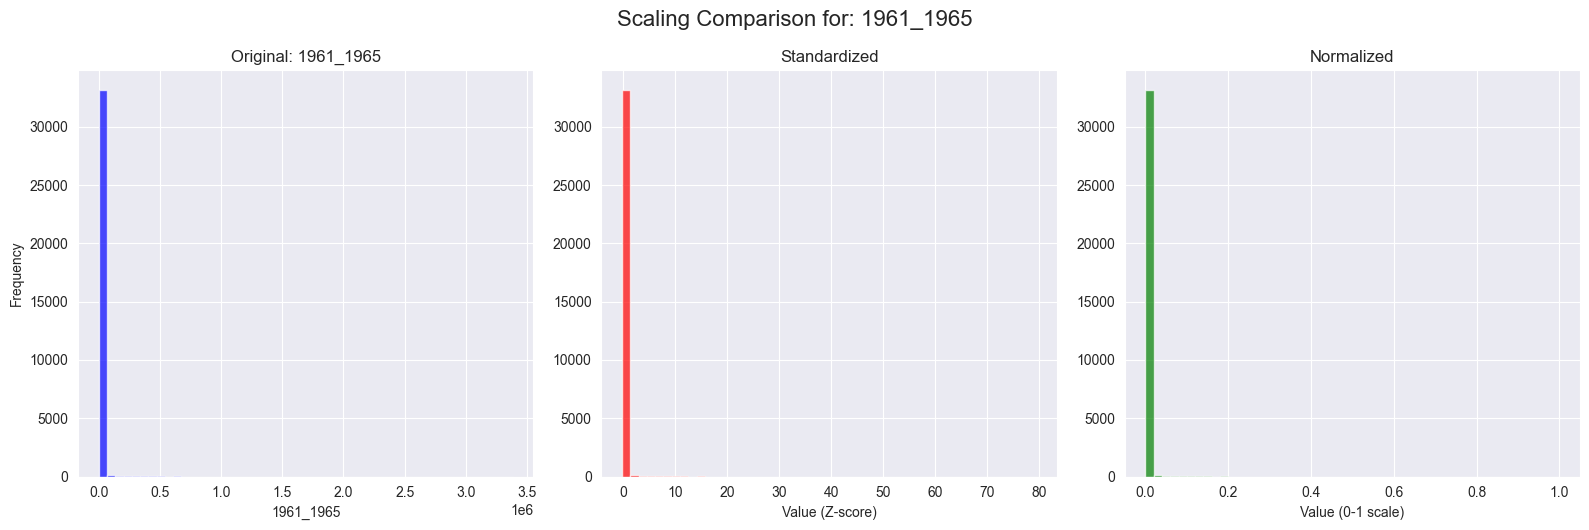

In [13]:
def plot_scaling_effect_separate(data_original, data_std, data_norm, column):
    plt.figure(figsize=(16, 5))

    # Original
    plt.subplot(1, 3, 1)
    plt.hist(data_original[column], bins=50, color='blue', alpha=0.7)
    plt.title(f"Original: {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")

    # Standardized
    plt.subplot(1, 3, 2)
    plt.hist(data_std[column], bins=50, color='red', alpha=0.7)
    plt.title("Standardized")
    plt.xlabel("Value (Z-score)")

    # Normalized
    plt.subplot(1, 3, 3)
    plt.hist(data_norm[column], bins=50, color='green', alpha=0.7)
    plt.title("Normalized")
    plt.xlabel("Value (0-1 scale)")

    plt.tight_layout()
    plt.suptitle(f"Scaling Comparison for: {column}", fontsize=16, y=1.05)
    plt.show()

# Example usage for one column:
plot_scaling_effect_separate(df_grouped, df_scaled_std, df_scaled_norm, '1961_1965')


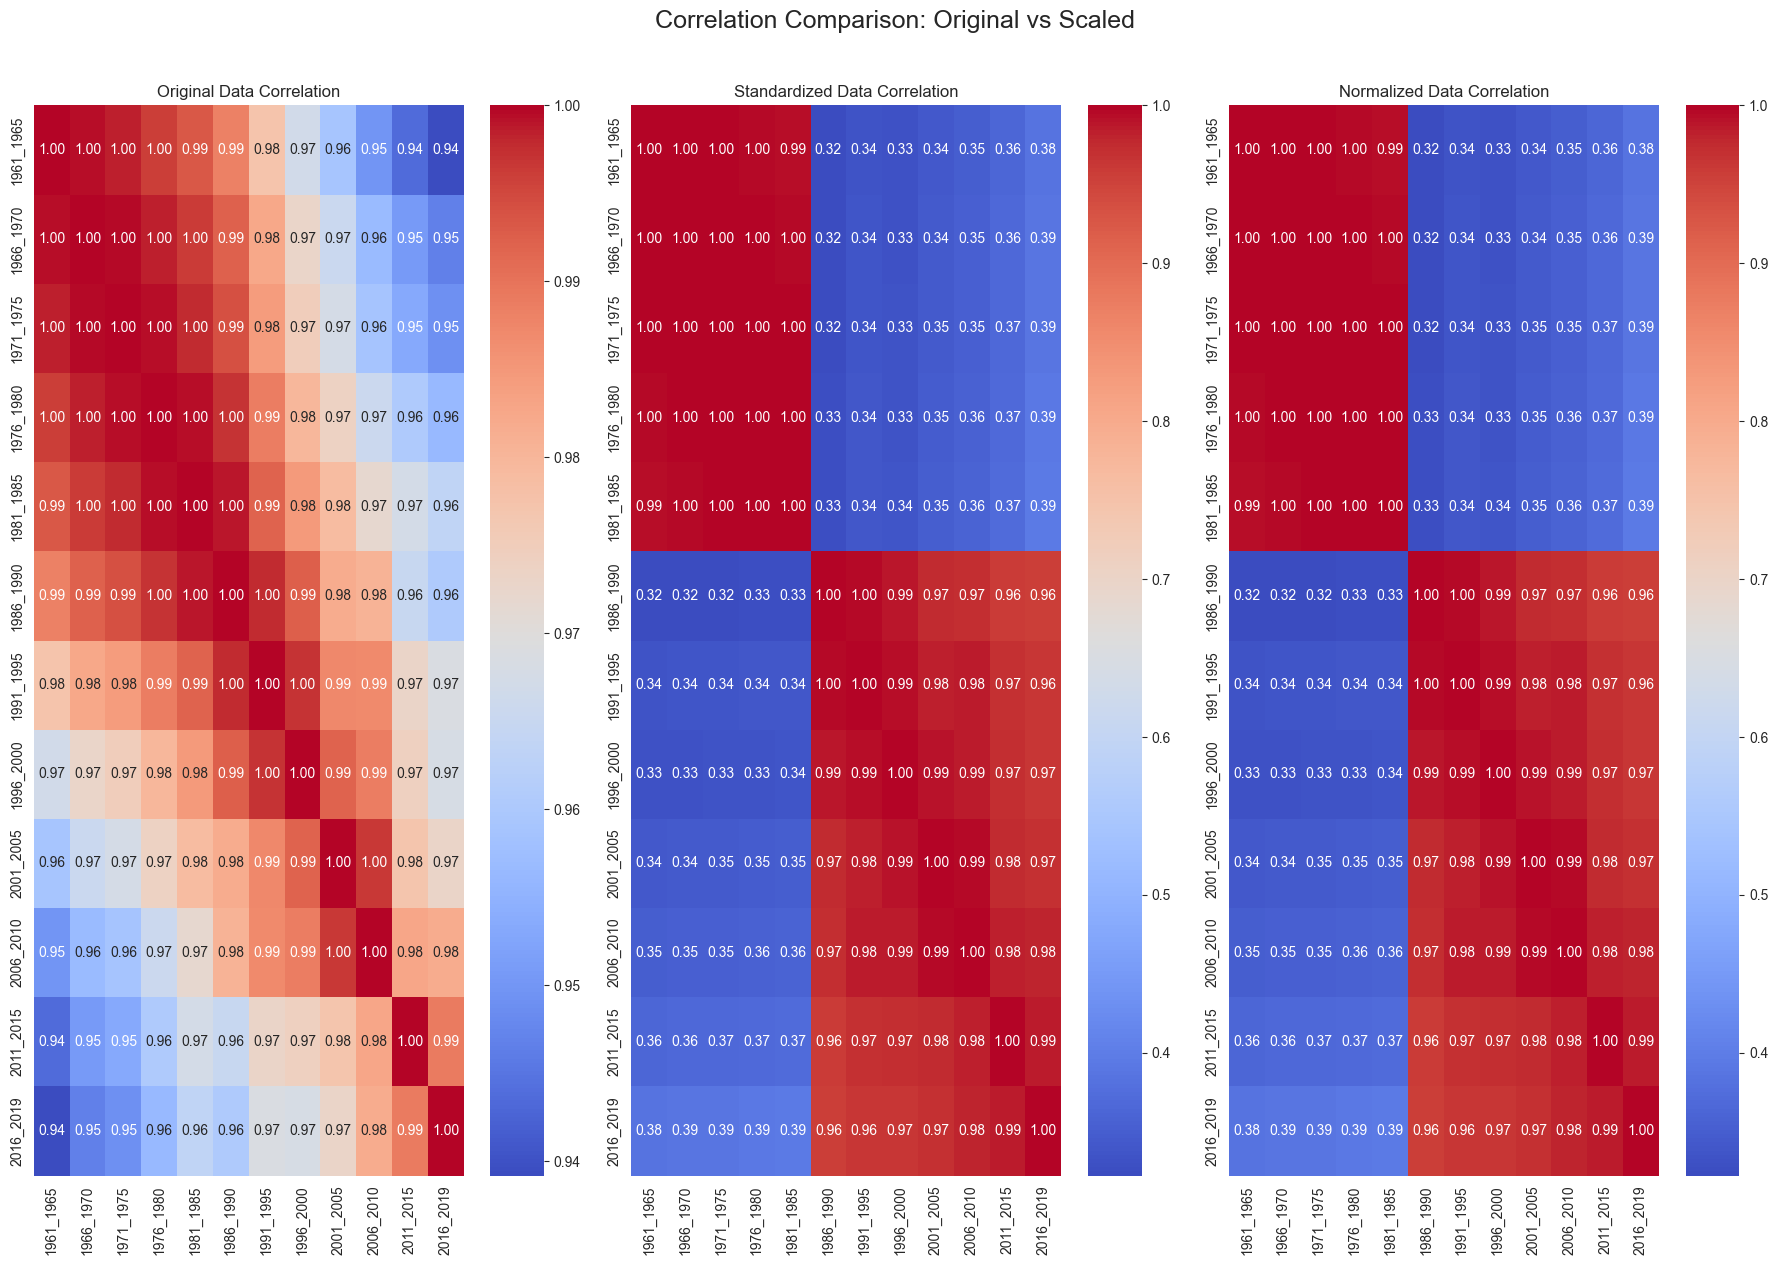

In [14]:


def plot_correlation_heatmaps(original, standardized, normalized, interval_cols):
    plt.figure(figsize=(18, 12))

    # Original
    plt.subplot(1, 3, 1)
    sns.heatmap(original[interval_cols].corr(), cmap='coolwarm', annot=True, fmt=".2f")
    plt.title("Original Data Correlation")

    # Standardized
    plt.subplot(1, 3, 2)
    sns.heatmap(standardized[interval_cols].corr(), cmap='coolwarm', annot=True, fmt=".2f")
    plt.title("Standardized Data Correlation")

    # Normalized
    plt.subplot(1, 3, 3)
    sns.heatmap(normalized[interval_cols].corr(), cmap='coolwarm', annot=True, fmt=".2f")
    plt.title("Normalized Data Correlation")

    plt.tight_layout()
    plt.suptitle("Correlation Comparison: Original vs Scaled", fontsize=18, y=1.05)
    plt.show()

# Run this for your data
plot_correlation_heatmaps(df_grouped_before, df_scaled_std, df_scaled_norm, interval_cols)


In [15]:
# Outlier Detection (Z-score method)
z_scores = np.abs((df_scaled_std[interval_cols] - df_scaled_std[interval_cols].mean()) / df_scaled_std[interval_cols].std())
outliers = (z_scores > 3)
print("Outliers detected:", outliers.sum().sum())

# Cap outliers to 3 std deviations
df_outlier_handled = df_scaled_std.copy()
for col in interval_cols:
    mean = df_outlier_handled[col].mean()
    std = df_outlier_handled[col].std()
    upper = mean + 3*std
    lower = mean - 3*std
    df_outlier_handled[col] = np.clip(df_outlier_handled[col], lower, upper)

Outliers detected: 2877


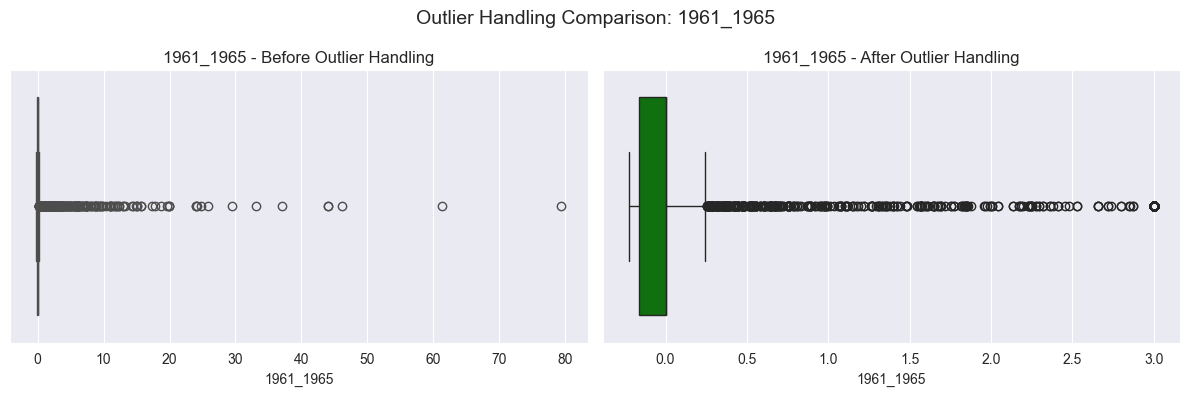

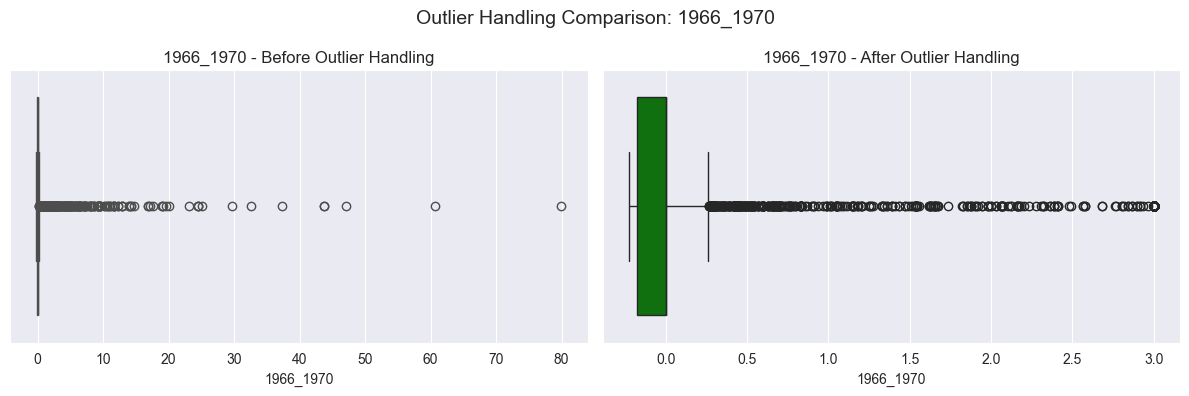

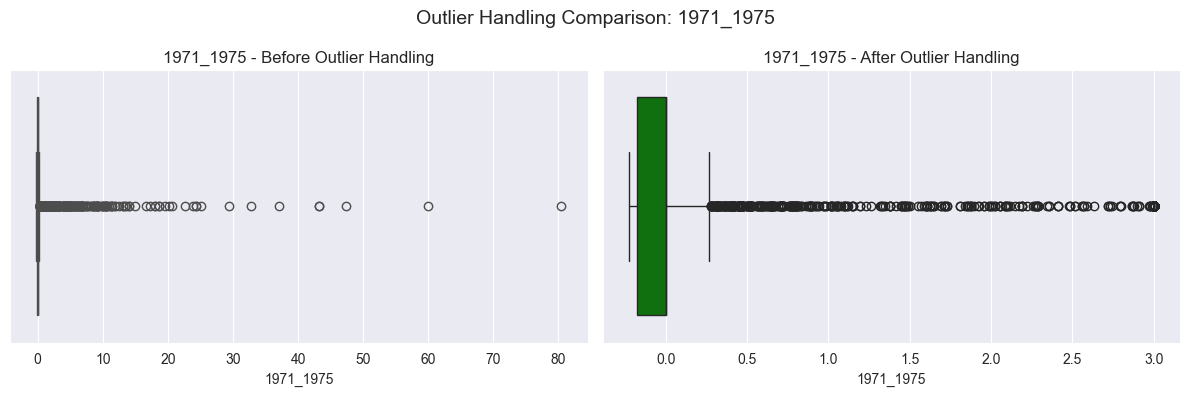

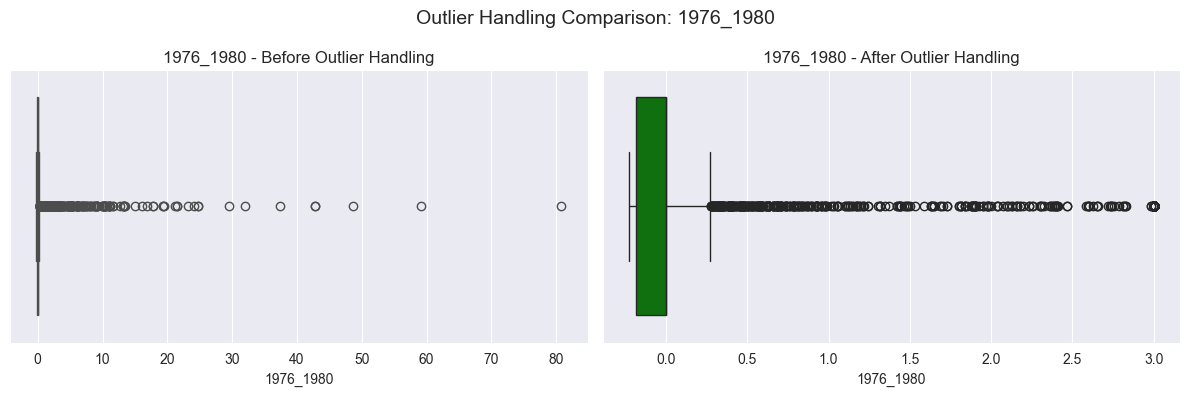

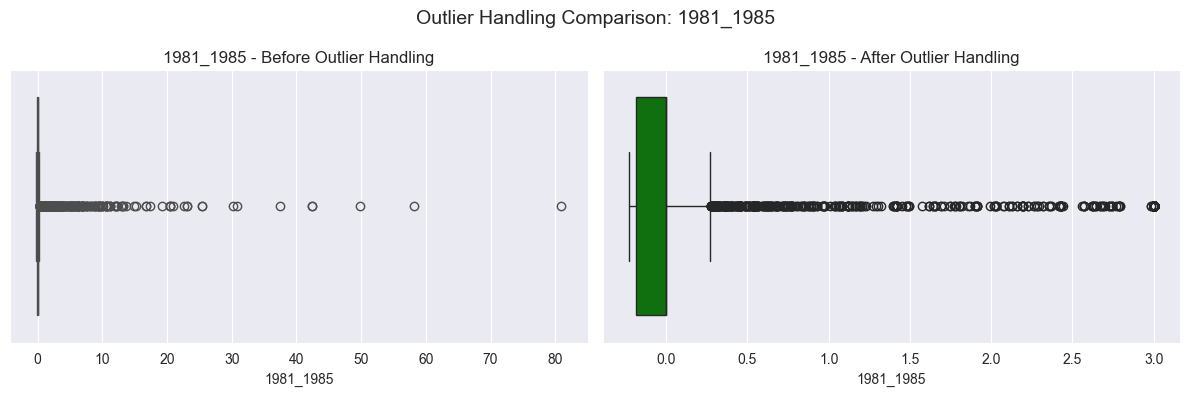

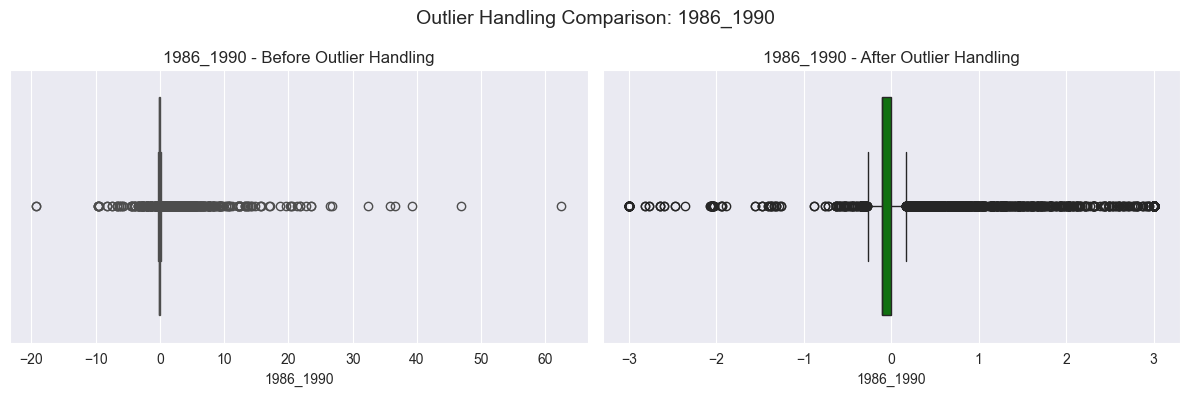

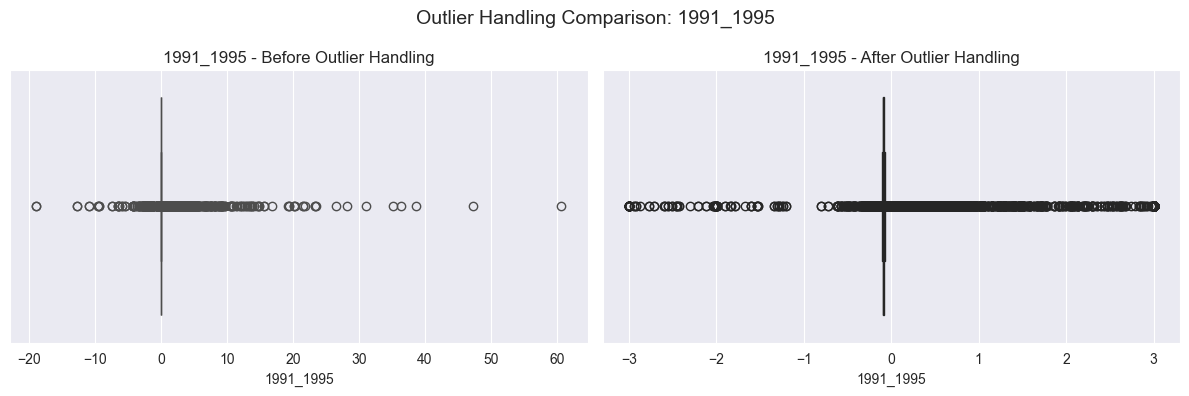

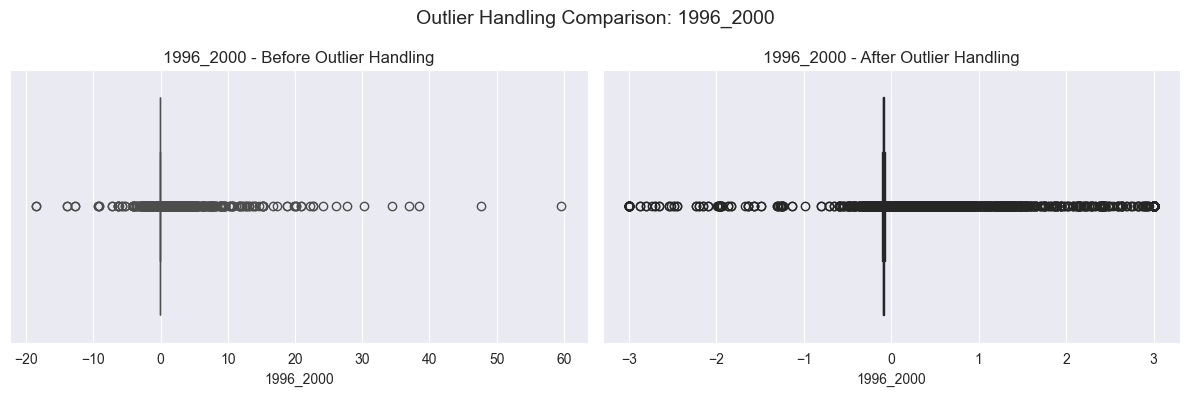

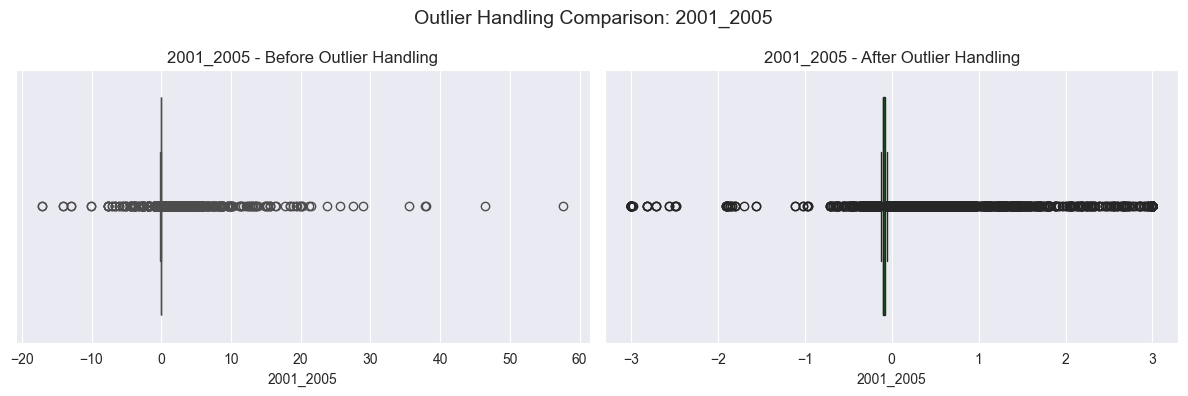

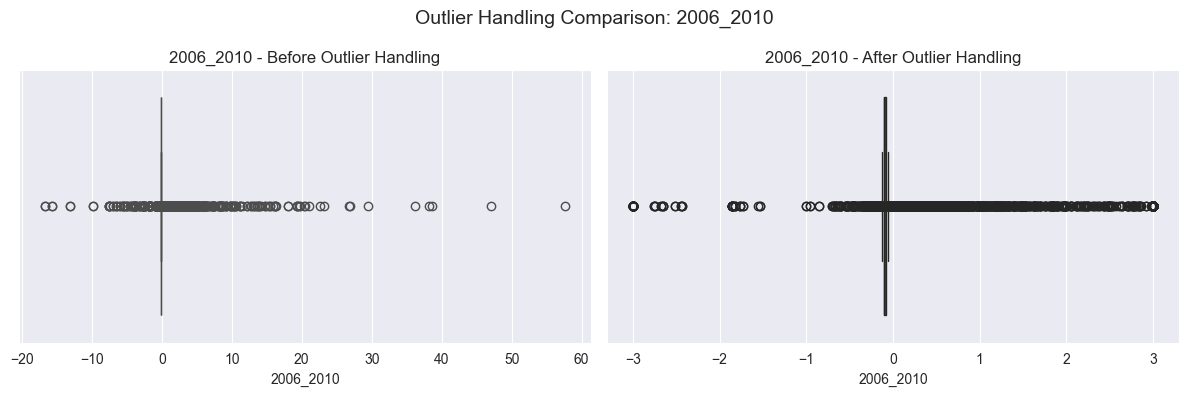

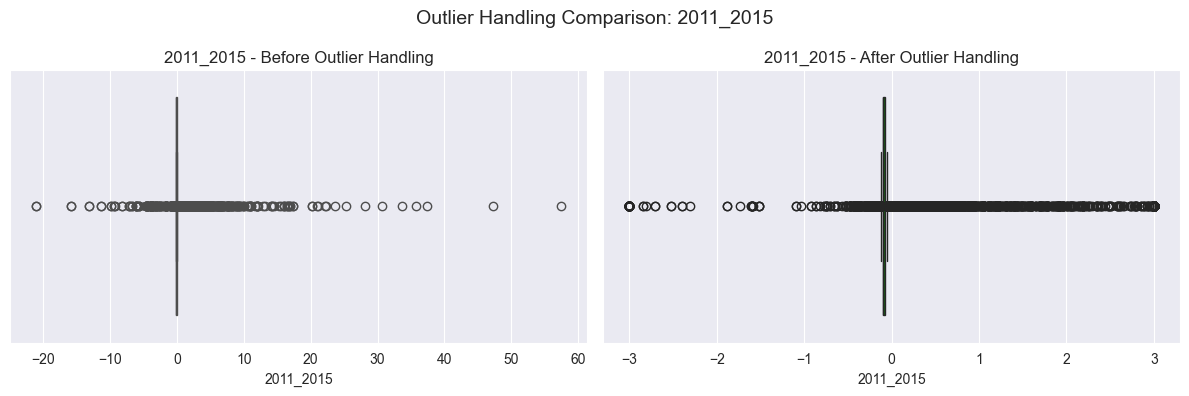

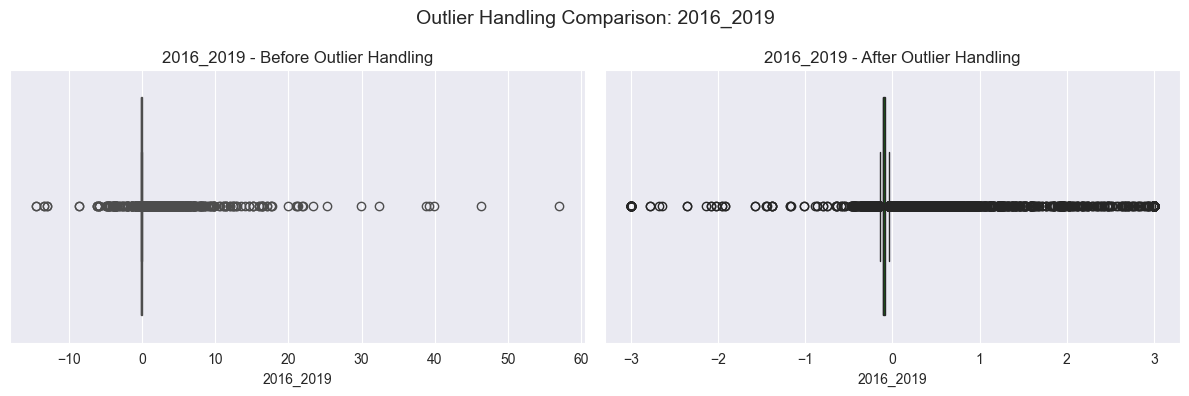

In [16]:


# Choose a few columns to visualize (not too many to keep it readable)
sample_cols = interval_cols[:]  # First 5 five-year columns

# Create before vs after boxplots side-by-side
for col in sample_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Before handling outliers
    sns.boxplot(data=df_scaled_std[col], ax=axes[0], color='orange', orient='h')
    axes[0].set_title(f"{col} - Before Outlier Handling")

    # After handling outliers
    sns.boxplot(data=df_outlier_handled[col], ax=axes[1], color='green', orient='h')
    axes[1].set_title(f"{col} - After Outlier Handling")

    plt.suptitle(f"Outlier Handling Comparison: {col}", fontsize=14)
    plt.tight_layout()
    plt.show()


In [17]:
# Encode categorical variables
label_enc = LabelEncoder()
for col in df_outlier_handled.select_dtypes(include='object').columns:
    df_outlier_handled[col] = label_enc.fit_transform(df_outlier_handled[col])

In [18]:
# Export cleaned dataset
df_outlier_handled.to_csv("cleaned_FAOSTAT.csv", index=False)
print("Cleaned dataset saved to cleaned_FAOSTAT.csv")

Cleaned dataset saved to cleaned_FAOSTAT.csv


In [19]:
# Load cleaned dataset
cleaned_df_path = "cleaned_FAOSTAT.csv"
df = pd.read_csv(cleaned_df_path)
print("Loaded cleaned dataset from:", cleaned_df_path)

# Identify 5-year interval columns
interval_cols = [col for col in df.columns if col.count('_') == 1 and col.replace('_','').isdigit()]

Loaded cleaned dataset from: cleaned_FAOSTAT.csv


In [20]:
# Assume target column (to predict) is the last 5-year interval
target_col = interval_cols[-1]  # Last 5-year interval is the target
past_interval_cols = interval_cols[:-1]  # Exclude target from inputs

 Feature Engineering 
Creating statistical summary features from past 5-year interval columns only (excluding target)
These features help capture overall trends and variability in the data for each row
- 5yr_mean: Average across all past 5-year interval columns
- 5yr_std: Standard deviation across all past 5-year interval columns

In [21]:



df['5yr_mean'] = df[past_interval_cols].mean(axis=1)
df['5yr_std'] = df[past_interval_cols].std(axis=1)


In [22]:
# Set features 
X = df.drop(columns=[target_col])
y = df[target_col]

In [23]:
# Encode categorical variables
label_enc = LabelEncoder()
for col in X.select_dtypes(include='object').columns:
    X[col] = label_enc.fit_transform(X[col])

In [24]:
# Scale numeric features for Linear Regression and XGBoost
X_scaled = X.copy()
X_scaled[past_interval_cols + ['5yr_mean', '5yr_std']] = StandardScaler().fit_transform(X_scaled[past_interval_cols + ['5yr_mean', '5yr_std']])


In [25]:
# Split data
X_train_lr, X_test_lr, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_rf, X_test_rf, _, _ = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_xgb, X_test_xgb, _, _ = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Model Implementation


In [26]:
# Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train_lr, y_train)
y_pred_lr = model_lr.predict(X_test_lr)

# Random Forest
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train_rf, y_train)
y_pred_rf = model_rf.predict(X_test_rf)

# XGBoost
model_xgb = XGBRegressor(random_state=42, verbosity=0)
model_xgb.fit(X_train_xgb, y_train)
y_pred_xgb = model_xgb.predict(X_test_xgb)

 Validation Metrics

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def print_metrics(y_true, y_pred, name):
    print(f"--- {name} ---")
    print("MSE (Mean Squared Error):", mean_squared_error(y_true, y_pred))
    print("MAE (Mean Absolute Error):", mean_absolute_error(y_true, y_pred))
    print("R-squared (R²):", r2_score(y_true, y_pred))
    print("Accuracy (approx, based on R²):", round(r2_score(y_true, y_pred) * 100, 2), "%")
    print()

print_metrics(y_test, y_pred_lr, "Linear Regression")
print_metrics(y_test, y_pred_rf, "Random Forest")
print_metrics(y_test, y_pred_xgb, "XGBoost")

--- Linear Regression ---
MSE (Mean Squared Error): 0.005407333310174972
MAE (Mean Absolute Error): 0.02113341408342418
R-squared (R²): 0.9617868907403427
Accuracy (approx, based on R²): 96.18 %

--- Random Forest ---
MSE (Mean Squared Error): 0.0013303504677438188
MAE (Mean Absolute Error): 0.005064148271698935
R-squared (R²): 0.9905985400082752
Accuracy (approx, based on R²): 99.06 %

--- XGBoost ---
MSE (Mean Squared Error): 0.0010537617281194402
MAE (Mean Absolute Error): 0.006553911164029277
R-squared (R²): 0.9925531662761564
Accuracy (approx, based on R²): 99.26 %



Cross-validation

In [28]:

scores_lr = cross_val_score(model_lr, X_scaled, y, cv=5, scoring='r2')
scores_rf = cross_val_score(model_rf, X, y, cv=5, scoring='r2')
scores_xgb = cross_val_score(model_xgb, X_scaled, y, cv=5, scoring='r2')
print("Linear Regression CV R-squared:", scores_lr.mean())
print("Random Forest CV R-squared:", scores_rf.mean())
print("XGBoost CV R-squared:", scores_xgb.mean())

Linear Regression CV R-squared: 0.7898082418078691
Random Forest CV R-squared: 0.834131527481488
XGBoost CV R-squared: 0.7758857533904318


Plot predictions

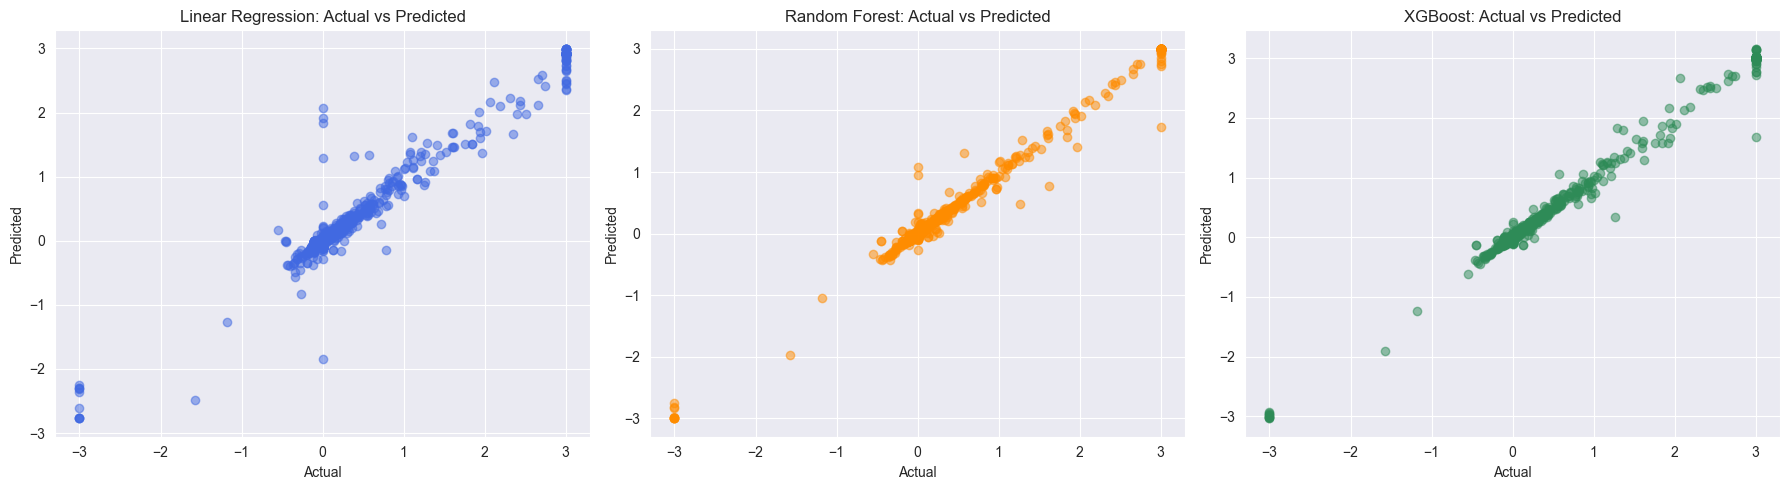

In [29]:

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_lr, alpha=0.5, color='royalblue')
plt.title("Linear Regression: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='darkorange')
plt.title("Random Forest: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='seagreen')
plt.title("XGBoost: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()

R², MSE, MAE, and Approx Accuracy Comparison

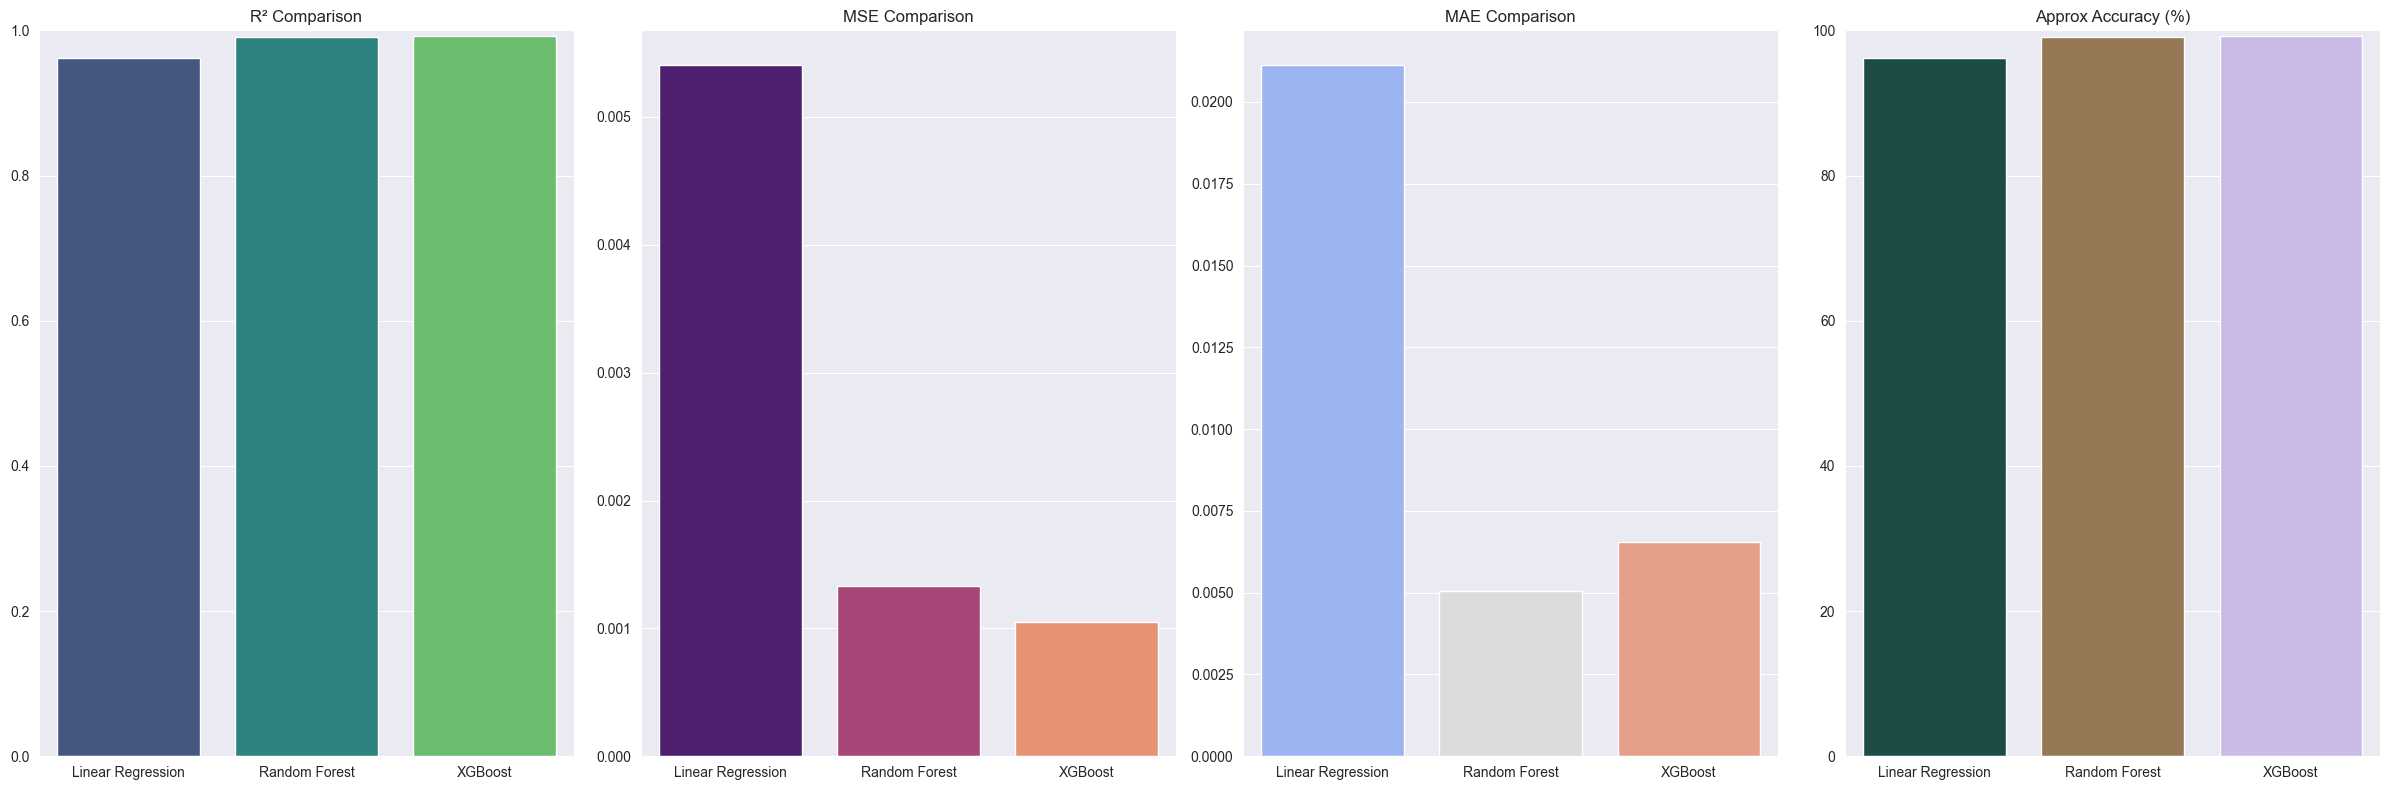

In [30]:

models = ['Linear Regression', 'Random Forest', 'XGBoost']
r2_scores = [r2_score(y_test, y_pred_lr), r2_score(y_test, y_pred_rf), r2_score(y_test, y_pred_xgb)]
mse_scores = [mean_squared_error(y_test, y_pred_lr), mean_squared_error(y_test, y_pred_rf), mean_squared_error(y_test, y_pred_xgb)]
mae_scores = [mean_absolute_error(y_test, y_pred_lr), mean_absolute_error(y_test, y_pred_rf), mean_absolute_error(y_test, y_pred_xgb)]
accuracy_scores = [r * 100 for r in r2_scores]  # Approximation of accuracy

plt.figure(figsize=(24, 8))
plt.subplot(1, 4, 1)
sns.barplot(x=models, y=r2_scores, hue=models, palette="viridis", legend=False)
plt.title("R² Comparison")
plt.ylim(0, 1)

plt.subplot(1, 4, 2)
sns.barplot(x=models, y=mse_scores, hue=models, palette="magma", legend=False)
plt.title("MSE Comparison")

plt.subplot(1, 4, 3)
sns.barplot(x=models, y=mae_scores, hue=models, palette="coolwarm", legend=False)
plt.title("MAE Comparison")

plt.subplot(1, 4, 4)
sns.barplot(x=models, y=accuracy_scores, hue=models, palette="cubehelix", legend=False)
plt.title("Approx Accuracy (%)")
plt.ylim(0, 100)

plt.tight_layout()
plt.show()